In [1]:
import pandas as pd
from preprocess import Audio_Processor
import data_utils as du
from sklearn import metrics
from keras.wrappers.scikit_learn import KerasClassifier
from classification_plots import plot_confusion_matrix, plot_learning_curve
import matplotlib.pyplot as plt
import os

Using TensorFlow backend.


Instructions for updating:
Use tf.initializers.variance_scaling instead with distribution=uniform to get equivalent behavior.


/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
# Able to specify which GPU to use
os.environ["CUDA_VISIBLE_DEVICES"]="1"

SR = 44100
blocksize = 88200
overlap = 22050

In [3]:
import warnings
warnings.filterwarnings('ignore')

# Setup

In [4]:
audio_dir = '../ESC-50/audio/'

In [5]:
path_to_db='../ESC-50/'
ps = Audio_Processor(path_to_db + 'audio/')

# Load Dataset
Here we load the csv that describes each file in the dataset. We add a high level category that is defined in the ESC-50 documentation. This we realize is anthetical to true training, it is a stopgap for when we use NLP to classify tags into these categories.

In [6]:
dataset = pd.read_csv(path_to_db + 'meta/esc50.csv')
classes = [None] * 50
h_classes = ['Human & Animal', 'Interacting Materials']

In [7]:
mapping = {'dog': 0,'rooster': 0,'pig': 0,'cow': 0,'frog': 0,'cat': 0,'hen': 0,
            'insects': 0,'sheep': 0,'crow': 0,'rain': 1,'sea_waves': 1,'crackling_fire': 1,
            'crickets': 0,'chirping_birds': 0,'water_drops': 1,'wind': 1,'pouring_water': 1,
            'toilet_flush': 1,'thunderstorm': 1,'crying_baby': 0,'sneezing': 0,'clapping': 0,
            'breathing': 0,'coughing': 0,'footsteps': 1,'laughing': 0,'brushing_teeth': 1,
            'snoring': 0,'drinking_sipping': 1,'door_wood_knock': 1,'mouse_click': 1,
            'keyboard_typing': 1,'door_wood_creaks': 1,'can_opening': 1,'washing_machine': 1,
            'vacuum_cleaner': 1,'clock_alarm': 1,'clock_tick': 1,'glass_breaking':1,'helicopter': 1,
            'chainsaw': 1,'siren': 1,'car_horn': 1,'engine': 1,'train': 1,'church_bells': 1,
            'airplane': 1,'fireworks': 1,'hand_saw': 1,
            }

In [8]:
dataset['h_category'] = None
for index, row in dataset.iterrows():
    target = row['target']
    classes[target] = row['category']
    dataset.loc[index, 'h_category'] = mapping[row['category']]

In [9]:
dataset.head()

,filename,fold,target,category,esc10,src_file,take,h_category
0,1-100032-A-0.wav,1,0,dog,True,100032,A,0
1,1-100038-A-14.wav,1,14,chirping_birds,False,100038,A,0
2,1-100210-A-36.wav,1,36,vacuum_cleaner,False,100210,A,1
3,1-100210-B-36.wav,1,36,vacuum_cleaner,False,100210,B,1
4,1-101296-A-19.wav,1,19,thunderstorm,False,101296,A,1


## Getting Preprocessed Data
We allow for previously preprocessed data to be retrieved for faster training turnaround. If the fold has been preprocessed, it is loaded but if not it is processed and saved.

In [10]:
df = ps.preprocess_fold(dataset, 
                        kind='mfcc', 
                        fld=range(2,6), 
                        blocksize=blocksize, 
                        overlap=overlap)

In [11]:
df.describe()

,0,1,2,3,4,5,6,7,8,9,...,106,107,108,109,110,111,112,113,l_target,h_target
count,4538.000000,4538.000000,4538.000000,4538.000000,4538.000000,4538.000000,4538.000000,4538.000000,4538.000000,4538.000000,...,4538.000000,4538.000000,4538.000000,4538.000000,4538.000000,4538.000000,4538.000000,4538.000000,4538.000000,4538.000000
mean,0.271778,0.277427,0.196409,0.172584,0.155856,0.147383,0.137123,0.137427,0.127727,0.125805,...,-0.000042,0.000060,-0.000030,0.000046,-0.000036,0.000034,-0.000015,0.000021,0.623402,24.497135
std,0.152690,0.154592,0.088349,0.075266,0.066213,0.060945,0.056277,0.057575,0.051265,0.050852,...,0.000670,0.000621,0.000643,0.000617,0.000649,0.000603,0.000628,0.000569,0.484586,14.519294
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-0.017461,-0.005907,-0.005809,-0.009156,-0.016274,-0.005280,-0.003952,-0.006403,0.000000,0.000000
25%,0.146685,0.143912,0.133364,0.120063,0.111619,0.106004,0.100349,0.097655,0.094181,0.091991,...,-0.000126,-0.000040,-0.000111,-0.000045,-0.000105,-0.000051,-0.000093,-0.000049,0.000000,12.000000
50%,0.255615,0.270452,0.197800,0.172240,0.155154,0.147672,0.136195,0.137088,0.127714,0.125865,...,-0.000029,0.000025,-0.000024,0.000015,-0.000021,0.000007,-0.000014,0.000004,1.000000,24.000000
75%,0.372589,0.387784,0.252908,0.220791,0.197310,0.184662,0.170713,0.173707,0.158522,0.156500,...,0.000032,0.000121,0.000035,0.000100,0.000036,0.000087,0.000043,0.000082,1.000000,37.000000
max,0.782623,0.839244,0.561361,0.483876,0.458426,0.454676,0.490386,0.424678,0.377254,0.407372,...,0.030503,0.030503,0.030503,0.030503,0.030503,0.030503,0.030503,0.030503,1.000000,49.000000


In [12]:
a_data = df[df['l_target'] == 0]
i_data = df[df['l_target'] == 1]

# Animal Sounds

In [13]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(a_data, test_size=0.20, random_state=56)

In [14]:
train_X = train.drop(['l_target', 'h_target'], axis=1)
train_y = train['h_target']
test_X = test.drop(['l_target', 'h_target'], axis=1)
test_y = test['h_target']

In [15]:
from keras.layers import Dense, Dropout
from keras.models import Sequential

def gpu_mfcc_deep_net_a():
    # Create Model
    model = Sequential()
    model.add(Dense(100, activation='relu', input_shape=(114,)))
    model.add(Dense(100, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(100, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.2))    
    model.add(Dense(19, kernel_initializer='normal', activation='softmax'))
    
    # Compile model
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    
    model.summary()

    
    return model

In [16]:
train_y.describe()

count    1367.000000
mean       12.137527
std         9.066460
min         0.000000
25%         4.000000
50%         9.000000
75%        21.000000
max        28.000000
Name: h_target, dtype: float64

In [17]:
anim = KerasClassifier(build_fn=gpu_mfcc_deep_net_a, 
                       epochs=500, 
                       batch_size=128, 
                       validation_split=0.15)
history = anim.fit(train_X, train_y)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100)               11500     
_________________________________________________________________
dense_2 (Dense)              (None, 100)               10100     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 100)               10100     
_________________________________________________________________
dropout_2 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 64)                6464      
_________________________________________________________________
dense_5 (Dense)              (None, 64)                4160      
__________

1161/1161 [==============================] - 0s 63us/step - loss: 2.2745 - acc: 0.2446 - val_loss: 2.4352 - val_acc: 0.2233
Epoch 45/500
1161/1161 [==============================] - 0s 67us/step - loss: 2.2762 - acc: 0.2532 - val_loss: 2.4082 - val_acc: 0.2427
Epoch 46/500
1161/1161 [==============================] - 0s 63us/step - loss: 2.2683 - acc: 0.2455 - val_loss: 2.4740 - val_acc: 0.2524
Epoch 47/500
1161/1161 [==============================] - 0s 62us/step - loss: 2.2612 - acc: 0.2584 - val_loss: 2.4325 - val_acc: 0.2573
Epoch 48/500
1161/1161 [==============================] - 0s 59us/step - loss: 2.2548 - acc: 0.2653 - val_loss: 2.4182 - val_acc: 0.2476
Epoch 49/500
1161/1161 [==============================] - 0s 56us/step - loss: 2.2437 - acc: 0.2584 - val_loss: 2.4149 - val_acc: 0.2961
Epoch 50/500
1161/1161 [==============================] - 0s 60us/step - loss: 2.2105 - acc: 0.2670 - val_loss: 2.3736 - val_acc: 0.2816
Epoch 51/500
1161/1161 [==============================

Epoch 104/500
1161/1161 [==============================] - 0s 62us/step - loss: 1.7534 - acc: 0.3971 - val_loss: 2.1040 - val_acc: 0.3835
Epoch 105/500
1161/1161 [==============================] - 0s 60us/step - loss: 1.7405 - acc: 0.4091 - val_loss: 2.1024 - val_acc: 0.3835
Epoch 106/500
1161/1161 [==============================] - 0s 57us/step - loss: 1.7295 - acc: 0.3867 - val_loss: 2.1053 - val_acc: 0.3544
Epoch 107/500
1161/1161 [==============================] - 0s 62us/step - loss: 1.7067 - acc: 0.4031 - val_loss: 2.2058 - val_acc: 0.3641
Epoch 108/500
1161/1161 [==============================] - 0s 63us/step - loss: 1.7995 - acc: 0.3833 - val_loss: 2.0388 - val_acc: 0.3641
Epoch 109/500
1161/1161 [==============================] - 0s 61us/step - loss: 1.8355 - acc: 0.3945 - val_loss: 2.3185 - val_acc: 0.3447
Epoch 110/500
1161/1161 [==============================] - 0s 61us/step - loss: 1.8264 - acc: 0.3833 - val_loss: 2.1519 - val_acc: 0.4029
Epoch 111/500
1161/1161 [=========

1161/1161 [==============================] - 0s 61us/step - loss: 1.3685 - acc: 0.5185 - val_loss: 2.0424 - val_acc: 0.4660
Epoch 164/500
1161/1161 [==============================] - 0s 61us/step - loss: 1.5739 - acc: 0.4755 - val_loss: 2.1827 - val_acc: 0.4126
Epoch 165/500
1161/1161 [==============================] - 0s 63us/step - loss: 1.4755 - acc: 0.5090 - val_loss: 2.0369 - val_acc: 0.4417
Epoch 166/500
1161/1161 [==============================] - 0s 63us/step - loss: 1.5367 - acc: 0.4634 - val_loss: 2.1756 - val_acc: 0.3883
Epoch 167/500
1161/1161 [==============================] - 0s 65us/step - loss: 1.5108 - acc: 0.4918 - val_loss: 2.1794 - val_acc: 0.4417
Epoch 168/500
1161/1161 [==============================] - 0s 63us/step - loss: 1.4476 - acc: 0.5056 - val_loss: 2.0628 - val_acc: 0.4126
Epoch 169/500
1161/1161 [==============================] - 0s 63us/step - loss: 1.5193 - acc: 0.5056 - val_loss: 2.0983 - val_acc: 0.4223
Epoch 170/500
1161/1161 [=======================

1161/1161 [==============================] - 0s 64us/step - loss: 1.1383 - acc: 0.5797 - val_loss: 2.0596 - val_acc: 0.5000
Epoch 223/500
1161/1161 [==============================] - 0s 63us/step - loss: 1.1217 - acc: 0.6227 - val_loss: 2.1797 - val_acc: 0.4757
Epoch 224/500
1161/1161 [==============================] - 0s 65us/step - loss: 1.1889 - acc: 0.5935 - val_loss: 2.0401 - val_acc: 0.4563
Epoch 225/500
1161/1161 [==============================] - 0s 62us/step - loss: 1.1349 - acc: 0.6038 - val_loss: 1.9757 - val_acc: 0.5049
Epoch 226/500
1161/1161 [==============================] - 0s 62us/step - loss: 1.1338 - acc: 0.6029 - val_loss: 1.9889 - val_acc: 0.5097
Epoch 227/500
1161/1161 [==============================] - 0s 62us/step - loss: 1.0786 - acc: 0.6305 - val_loss: 2.0118 - val_acc: 0.5291
Epoch 228/500
1161/1161 [==============================] - 0s 59us/step - loss: 1.0919 - acc: 0.6202 - val_loss: 1.9968 - val_acc: 0.4951
Epoch 229/500
1161/1161 [=======================

1161/1161 [==============================] - 0s 60us/step - loss: 0.9477 - acc: 0.6581 - val_loss: 2.1456 - val_acc: 0.5388
Epoch 282/500
1161/1161 [==============================] - 0s 62us/step - loss: 0.9428 - acc: 0.6520 - val_loss: 2.1147 - val_acc: 0.5194
Epoch 283/500
1161/1161 [==============================] - 0s 62us/step - loss: 0.9071 - acc: 0.6830 - val_loss: 2.1848 - val_acc: 0.5437
Epoch 284/500
1161/1161 [==============================] - 0s 61us/step - loss: 0.9554 - acc: 0.6649 - val_loss: 2.1710 - val_acc: 0.5243
Epoch 285/500
1161/1161 [==============================] - 0s 61us/step - loss: 0.9810 - acc: 0.6658 - val_loss: 2.2573 - val_acc: 0.5243
Epoch 286/500
1161/1161 [==============================] - 0s 60us/step - loss: 0.9756 - acc: 0.6477 - val_loss: 2.2100 - val_acc: 0.4951
Epoch 287/500
1161/1161 [==============================] - 0s 62us/step - loss: 1.0007 - acc: 0.6486 - val_loss: 2.2626 - val_acc: 0.5437
Epoch 288/500
1161/1161 [=======================

1161/1161 [==============================] - 0s 62us/step - loss: 0.8335 - acc: 0.7046 - val_loss: 2.1809 - val_acc: 0.5388
Epoch 341/500
1161/1161 [==============================] - 0s 63us/step - loss: 0.8483 - acc: 0.7175 - val_loss: 2.1899 - val_acc: 0.5388
Epoch 342/500
1161/1161 [==============================] - 0s 59us/step - loss: 0.7996 - acc: 0.7106 - val_loss: 2.1961 - val_acc: 0.5534
Epoch 343/500
1161/1161 [==============================] - 0s 62us/step - loss: 0.8433 - acc: 0.7028 - val_loss: 2.1875 - val_acc: 0.5340
Epoch 344/500
1161/1161 [==============================] - 0s 63us/step - loss: 0.7851 - acc: 0.7321 - val_loss: 2.1662 - val_acc: 0.5437
Epoch 345/500
1161/1161 [==============================] - 0s 63us/step - loss: 0.7581 - acc: 0.7278 - val_loss: 2.1350 - val_acc: 0.5922
Epoch 346/500
1161/1161 [==============================] - 0s 66us/step - loss: 0.7512 - acc: 0.7192 - val_loss: 2.1528 - val_acc: 0.5340
Epoch 347/500
1161/1161 [=======================

1161/1161 [==============================] - 0s 61us/step - loss: 0.7230 - acc: 0.7562 - val_loss: 2.1682 - val_acc: 0.5971
Epoch 400/500
1161/1161 [==============================] - 0s 63us/step - loss: 0.7503 - acc: 0.7649 - val_loss: 2.0626 - val_acc: 0.5680
Epoch 401/500
1161/1161 [==============================] - 0s 62us/step - loss: 0.7058 - acc: 0.7606 - val_loss: 2.0748 - val_acc: 0.5777
Epoch 402/500
1161/1161 [==============================] - 0s 60us/step - loss: 0.6768 - acc: 0.7640 - val_loss: 2.3073 - val_acc: 0.5825
Epoch 403/500
1161/1161 [==============================] - 0s 59us/step - loss: 0.7852 - acc: 0.7183 - val_loss: 2.4761 - val_acc: 0.5534
Epoch 404/500
1161/1161 [==============================] - 0s 63us/step - loss: 0.7276 - acc: 0.7485 - val_loss: 2.2993 - val_acc: 0.5680
Epoch 405/500
1161/1161 [==============================] - 0s 62us/step - loss: 0.7274 - acc: 0.7640 - val_loss: 2.2317 - val_acc: 0.5874
Epoch 406/500
1161/1161 [=======================

1161/1161 [==============================] - 0s 63us/step - loss: 0.6970 - acc: 0.7812 - val_loss: 2.1844 - val_acc: 0.6019
Epoch 459/500
1161/1161 [==============================] - 0s 63us/step - loss: 0.7293 - acc: 0.7494 - val_loss: 2.2582 - val_acc: 0.5728
Epoch 460/500
1161/1161 [==============================] - 0s 64us/step - loss: 0.7156 - acc: 0.7614 - val_loss: 2.4119 - val_acc: 0.5728
Epoch 461/500
1161/1161 [==============================] - 0s 59us/step - loss: 0.6659 - acc: 0.7726 - val_loss: 2.2579 - val_acc: 0.5874
Epoch 462/500
1161/1161 [==============================] - 0s 59us/step - loss: 0.6644 - acc: 0.7795 - val_loss: 2.2547 - val_acc: 0.5825
Epoch 463/500
1161/1161 [==============================] - 0s 67us/step - loss: 0.7537 - acc: 0.7588 - val_loss: 2.2691 - val_acc: 0.5534
Epoch 464/500
1161/1161 [==============================] - 0s 65us/step - loss: 0.7145 - acc: 0.7717 - val_loss: 2.2255 - val_acc: 0.6068
Epoch 465/500
1161/1161 [=======================

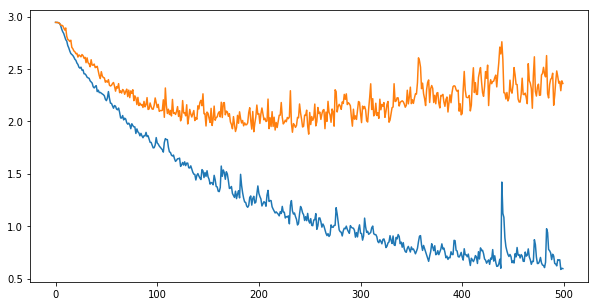

In [18]:
plt.figure(figsize=(10, 5))
# plt.ylim([0,9])
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.show()

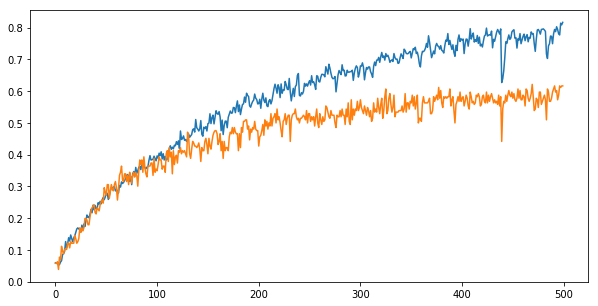

In [19]:
plt.figure(figsize=(10, 5))
# plt.ylim([0,9])
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.show()

0.5526315789473685
Confusion matrix, without normalization
[[ 9  2  0  0  0  0  1  0  0  0  0  0  0  4  0  1  0  0  0]
 [ 1  6  0  0  0  1  0  0  0  0  0  2  0  1  0  6  0  1  0]
 [ 0  1  8  0  0  0  0  0  0  0  0  0  0  1  0  1  0  0  1]
 [ 0  0  0  8  0  0  1  3  3  0  0  0  0  0  0  1  0  0  0]
 [ 0  0  0  0 12  1  0  0  3  0  1  0  1  0  0  4  0  0  0]
 [ 0  4  1  0  0  6  0  1  0  0  0  0  0  0  0  0  0  0  0]
 [ 4  0  0  0  0  2  8  1  0  0  0  1  0  2  0  0  0  1  0]
 [ 0  0  0  1  0  0  2 14  0  0  1  0  0  0  0  1  0  0  1]
 [ 1  0  0  2  0  1  0  0 10  2  0  0  0  0  2  0  1  1  0]
 [ 0  0  0  0  1  1  0  0  1  6  0  0  1  1  0  2  0  0  1]
 [ 0  0  0  0  0  0  0  0  0  0 19  0  0  0  0  0  0  0  2]
 [ 0  0  0  0  0  1  0  0  1  0  1 12  2  1  0  0  0  0  0]
 [ 0  1  0  0  0  0  0  0  0  0  0  2 10  0  1  1  0  1  0]
 [ 0  1  1  0  0  0  0  0  0  0  0  0  0  8  0  0  3  1  0]
 [ 0  0  0  0  0  2  0  0  0  0  0  0  0  0 19  1  0  0  0]
 [ 0  1  2  1  1  0  0  0  0  0  0  0  0 

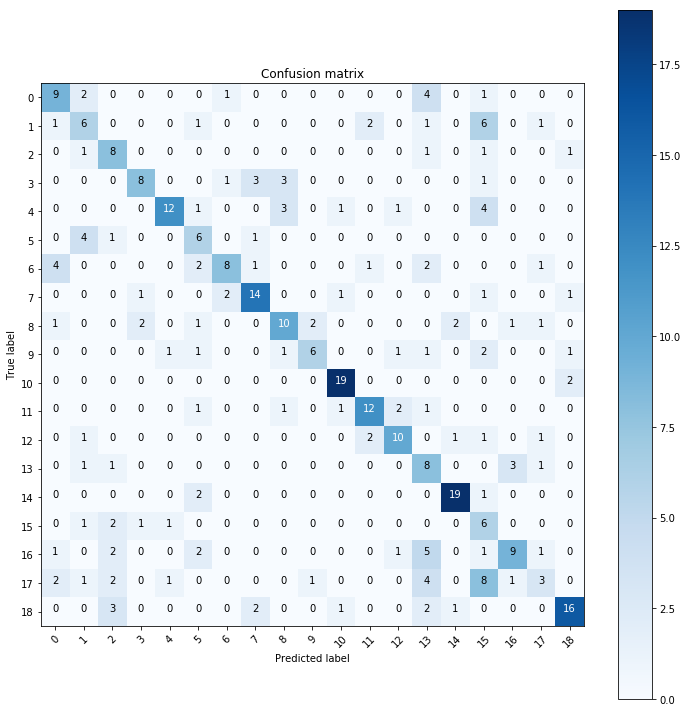

In [20]:
pred = anim.predict(test_X)
print(metrics.accuracy_score(test_y, pred))
cm = metrics.confusion_matrix(test_y, pred)
plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, range(0,19))
plt.show()

# Interacting Materials

In [21]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(i_data, test_size=0.20, random_state=56)

In [22]:
train_X = train.drop(['l_target', 'h_target'], axis=1)
train_y = train['h_target']
test_X = test.drop(['l_target', 'h_target'], axis=1)
test_y = test['h_target']

In [23]:
def gpu_mfcc_deep_net_i():
    # Create Model
    model = Sequential()
    model.add(Dense(100, activation='relu', input_shape=(114,)))
    model.add(Dropout(0.2))
    model.add(Dense(100, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(31, kernel_initializer='normal', activation='softmax'))
    
    # Compile model
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    
    model.summary()

    
    return model

In [24]:
inter = KerasClassifier(build_fn=gpu_mfcc_deep_net_i, epochs=500, batch_size=128, validation_split=0.15)
history = inter.fit(train_X, train_y)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_10 (Dense)             (None, 100)               11500     
_________________________________________________________________
dropout_6 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 100)               10100     
_________________________________________________________________
dropout_7 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 64)                6464      
_________________________________________________________________
dense_13 (Dense)             (None, 64)                4160      
_________________________________________________________________
dropout_8 (Dropout)          (None, 64)                0         
__________

1923/1923 [==============================] - 0s 54us/step - loss: 2.3995 - acc: 0.2293 - val_loss: 2.4104 - val_acc: 0.2324
Epoch 49/500
1923/1923 [==============================] - 0s 57us/step - loss: 2.3806 - acc: 0.2194 - val_loss: 2.4182 - val_acc: 0.2118
Epoch 50/500
1923/1923 [==============================] - 0s 55us/step - loss: 2.3799 - acc: 0.2252 - val_loss: 2.4011 - val_acc: 0.2353
Epoch 51/500
1923/1923 [==============================] - 0s 53us/step - loss: 2.3842 - acc: 0.2168 - val_loss: 2.4283 - val_acc: 0.2176
Epoch 52/500
1923/1923 [==============================] - 0s 53us/step - loss: 2.4028 - acc: 0.2231 - val_loss: 2.3975 - val_acc: 0.2765
Epoch 53/500
1923/1923 [==============================] - 0s 55us/step - loss: 2.3909 - acc: 0.2215 - val_loss: 2.4177 - val_acc: 0.2235
Epoch 54/500
1923/1923 [==============================] - 0s 55us/step - loss: 2.3950 - acc: 0.2194 - val_loss: 2.4062 - val_acc: 0.2500
Epoch 55/500
1923/1923 [==============================

Epoch 108/500
1923/1923 [==============================] - 0s 54us/step - loss: 2.0614 - acc: 0.3276 - val_loss: 2.0846 - val_acc: 0.3941
Epoch 109/500
1923/1923 [==============================] - 0s 52us/step - loss: 2.0355 - acc: 0.3297 - val_loss: 2.0896 - val_acc: 0.3882
Epoch 110/500
1923/1923 [==============================] - 0s 54us/step - loss: 2.0707 - acc: 0.3209 - val_loss: 2.0723 - val_acc: 0.3853
Epoch 111/500
1923/1923 [==============================] - 0s 55us/step - loss: 2.0571 - acc: 0.3375 - val_loss: 2.0824 - val_acc: 0.3941
Epoch 112/500
1923/1923 [==============================] - 0s 54us/step - loss: 2.0327 - acc: 0.3255 - val_loss: 2.0607 - val_acc: 0.4000
Epoch 113/500
1923/1923 [==============================] - 0s 54us/step - loss: 2.0308 - acc: 0.3354 - val_loss: 2.0608 - val_acc: 0.4000
Epoch 114/500
1923/1923 [==============================] - 0s 55us/step - loss: 2.0287 - acc: 0.3339 - val_loss: 2.0422 - val_acc: 0.3912
Epoch 115/500
1923/1923 [=========

1923/1923 [==============================] - 0s 55us/step - loss: 1.8126 - acc: 0.4129 - val_loss: 1.9044 - val_acc: 0.4471
Epoch 168/500
1923/1923 [==============================] - 0s 53us/step - loss: 1.8271 - acc: 0.4015 - val_loss: 1.9321 - val_acc: 0.4412
Epoch 169/500
1923/1923 [==============================] - 0s 58us/step - loss: 1.7984 - acc: 0.4290 - val_loss: 1.9239 - val_acc: 0.4382
Epoch 170/500
1923/1923 [==============================] - 0s 60us/step - loss: 1.7901 - acc: 0.4306 - val_loss: 1.8754 - val_acc: 0.4382
Epoch 171/500
1923/1923 [==============================] - 0s 59us/step - loss: 1.8027 - acc: 0.4103 - val_loss: 1.8841 - val_acc: 0.4353
Epoch 172/500
1923/1923 [==============================] - 0s 60us/step - loss: 1.8233 - acc: 0.4093 - val_loss: 1.8804 - val_acc: 0.4294
Epoch 173/500
1923/1923 [==============================] - 0s 60us/step - loss: 1.8050 - acc: 0.4139 - val_loss: 1.8750 - val_acc: 0.4471
Epoch 174/500
1923/1923 [=======================

1923/1923 [==============================] - 0s 58us/step - loss: 1.6084 - acc: 0.4732 - val_loss: 1.7528 - val_acc: 0.4882
Epoch 227/500
1923/1923 [==============================] - 0s 54us/step - loss: 1.6254 - acc: 0.4633 - val_loss: 1.7801 - val_acc: 0.4824
Epoch 228/500
1923/1923 [==============================] - 0s 59us/step - loss: 1.6148 - acc: 0.4779 - val_loss: 1.7662 - val_acc: 0.4824
Epoch 229/500
1923/1923 [==============================] - 0s 61us/step - loss: 1.6408 - acc: 0.4675 - val_loss: 1.7996 - val_acc: 0.4824
Epoch 230/500
1923/1923 [==============================] - 0s 60us/step - loss: 1.5808 - acc: 0.4841 - val_loss: 1.7791 - val_acc: 0.5029
Epoch 231/500
1923/1923 [==============================] - 0s 61us/step - loss: 1.6153 - acc: 0.4711 - val_loss: 1.8011 - val_acc: 0.4794
Epoch 232/500
1923/1923 [==============================] - 0s 60us/step - loss: 1.5915 - acc: 0.4826 - val_loss: 1.7928 - val_acc: 0.4853
Epoch 233/500
1923/1923 [=======================

1923/1923 [==============================] - 0s 57us/step - loss: 1.5442 - acc: 0.4925 - val_loss: 1.7177 - val_acc: 0.5059
Epoch 286/500
1923/1923 [==============================] - 0s 56us/step - loss: 1.5600 - acc: 0.4961 - val_loss: 1.6933 - val_acc: 0.4882
Epoch 287/500
1923/1923 [==============================] - 0s 57us/step - loss: 1.4854 - acc: 0.5216 - val_loss: 1.7117 - val_acc: 0.5176
Epoch 288/500
1923/1923 [==============================] - 0s 55us/step - loss: 1.5036 - acc: 0.5159 - val_loss: 1.7202 - val_acc: 0.5118
Epoch 289/500
1923/1923 [==============================] - 0s 58us/step - loss: 1.5042 - acc: 0.5169 - val_loss: 1.7105 - val_acc: 0.5324
Epoch 290/500
1923/1923 [==============================] - 0s 58us/step - loss: 1.5561 - acc: 0.5018 - val_loss: 1.7442 - val_acc: 0.4853
Epoch 291/500
1923/1923 [==============================] - 0s 57us/step - loss: 1.5004 - acc: 0.5127 - val_loss: 1.6726 - val_acc: 0.5147
Epoch 292/500
1923/1923 [=======================

1923/1923 [==============================] - 0s 50us/step - loss: 1.4268 - acc: 0.5403 - val_loss: 1.7371 - val_acc: 0.5324
Epoch 345/500
1923/1923 [==============================] - 0s 53us/step - loss: 1.4143 - acc: 0.5424 - val_loss: 1.7163 - val_acc: 0.5353
Epoch 346/500
1923/1923 [==============================] - 0s 55us/step - loss: 1.4013 - acc: 0.5502 - val_loss: 1.6893 - val_acc: 0.5412
Epoch 347/500
1923/1923 [==============================] - 0s 53us/step - loss: 1.3743 - acc: 0.5637 - val_loss: 1.6895 - val_acc: 0.5235
Epoch 348/500
1923/1923 [==============================] - 0s 53us/step - loss: 1.4260 - acc: 0.5356 - val_loss: 1.6943 - val_acc: 0.5147
Epoch 349/500
1923/1923 [==============================] - 0s 54us/step - loss: 1.4496 - acc: 0.5481 - val_loss: 1.6753 - val_acc: 0.5324
Epoch 350/500
1923/1923 [==============================] - 0s 55us/step - loss: 1.3975 - acc: 0.5533 - val_loss: 1.6738 - val_acc: 0.5324
Epoch 351/500
1923/1923 [=======================

1923/1923 [==============================] - 0s 59us/step - loss: 1.2989 - acc: 0.5798 - val_loss: 1.6149 - val_acc: 0.5500
Epoch 404/500
1923/1923 [==============================] - 0s 58us/step - loss: 1.2799 - acc: 0.5928 - val_loss: 1.6185 - val_acc: 0.5382
Epoch 405/500
1923/1923 [==============================] - 0s 60us/step - loss: 1.2946 - acc: 0.5835 - val_loss: 1.6386 - val_acc: 0.5441
Epoch 406/500
1923/1923 [==============================] - 0s 60us/step - loss: 1.2575 - acc: 0.5996 - val_loss: 1.6725 - val_acc: 0.5412
Epoch 407/500
1923/1923 [==============================] - 0s 57us/step - loss: 1.2727 - acc: 0.5850 - val_loss: 1.6299 - val_acc: 0.5559
Epoch 408/500
1923/1923 [==============================] - 0s 57us/step - loss: 1.2639 - acc: 0.5824 - val_loss: 1.6395 - val_acc: 0.5441
Epoch 409/500
1923/1923 [==============================] - 0s 55us/step - loss: 1.2954 - acc: 0.5835 - val_loss: 1.6321 - val_acc: 0.5471
Epoch 410/500
1923/1923 [=======================

1923/1923 [==============================] - 0s 53us/step - loss: 1.2922 - acc: 0.5809 - val_loss: 1.6444 - val_acc: 0.5529
Epoch 463/500
1923/1923 [==============================] - 0s 54us/step - loss: 1.2252 - acc: 0.5985 - val_loss: 1.6453 - val_acc: 0.5588
Epoch 464/500
1923/1923 [==============================] - 0s 54us/step - loss: 1.2090 - acc: 0.6001 - val_loss: 1.6114 - val_acc: 0.5735
Epoch 465/500
1923/1923 [==============================] - 0s 54us/step - loss: 1.1811 - acc: 0.6095 - val_loss: 1.6246 - val_acc: 0.5559
Epoch 466/500
1923/1923 [==============================] - 0s 55us/step - loss: 1.1996 - acc: 0.6136 - val_loss: 1.6838 - val_acc: 0.5559
Epoch 467/500
1923/1923 [==============================] - 0s 54us/step - loss: 1.2308 - acc: 0.5965 - val_loss: 1.6195 - val_acc: 0.5500
Epoch 468/500
1923/1923 [==============================] - 0s 50us/step - loss: 1.2462 - acc: 0.5949 - val_loss: 1.6669 - val_acc: 0.5382
Epoch 469/500
1923/1923 [=======================

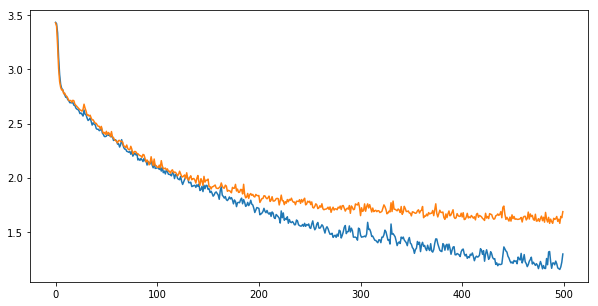

In [25]:
plt.figure(figsize=(10, 5))
# plt.ylim([0,9])
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.show()

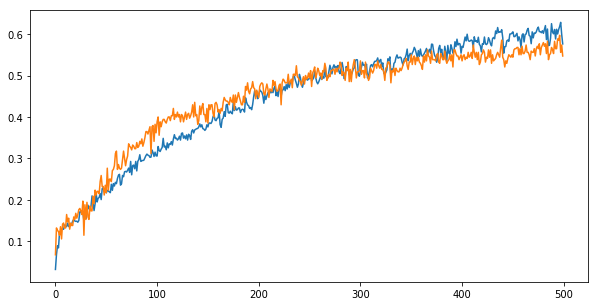

In [26]:
plt.figure(figsize=(10, 5))
# plt.ylim([0,9])
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.show()

0.5247349823321554
Confusion matrix, without normalization
[[16  4  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  1  0  0  0]
 [ 1 10  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0
   0  0  2  0  0  0  0]
 [ 0  0 24  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0]
 [ 0  0  0  9  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  2  0  0  0
   0  0  0  0  0  0  0]
 [ 0  0  0  0 14  0  0  0  0  0  0  0  0  0  0  0  2  0  0  0  0  3  0  0
   2  0  0  2  3  0  0]
 [ 0  0  0  0  0 13  1  0  0  0  0  0  1  0  0  1  0  0  1  0  2  0  0  0
   0  0  0  0  0  0  1]
 [ 3  4  1  0  0  1  3  0  0  0  1  0  0  0  2  0  0  1  0  0  1  0  1  0
   0  2  1  0  0  0  0]
 [ 0  0  0  1  0  0  0 12  0  0  0  2  0  0  2  0  0  0  0  0  0  0  0  0
   0  0  0  3  0  0  0]
 [ 1  0  0  5  0  0  0  0  8  1  0  1  0  0  0  0  0  0  1  1  0  0  0  0
   0  0  0  0  0  1  1]
 [ 0  0  0  0  0  1  1  0  2 13  0  0  0  0  0  0  0  0  0 

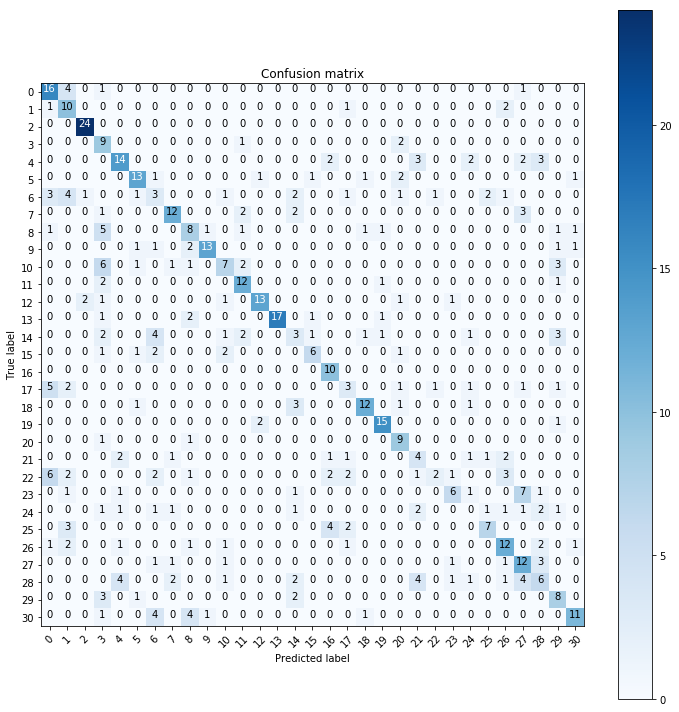

In [27]:
pred = inter.predict(test_X)
print(metrics.accuracy_score(test_y, pred))
cm = metrics.confusion_matrix(test_y, pred)
plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, range(0,31))
plt.show()

# All Data

In [28]:
all_df = ps.preprocess_fold(dataset, 
                        kind='mfcc', 
                        fld=1, 
                        blocksize=blocksize, 
                        overlap=overlap)

In [29]:
all_a_data = all_df[all_df['l_target'] == 0]
all_i_data = all_df[all_df['l_target'] == 1]

In [30]:
X = all_a_data.drop(['l_target', 'h_target'], axis=1)
y = all_a_data['h_target']

0.27488151658767773
Confusion matrix, without normalization
[[11  0  1  0  0  0  0  3  0  0  0  0  0  0  0  2  0  2  0]
 [ 0  4  0  0  0  2  0  0  0  0  0  1  1  2  0  5  0  3  0]
 [ 0  0  1  6  0  0  0  8  1  0  0  1  1  1  1  1  0  1  2]
 [ 5  2  0  7  1  1  0  0  0  1  0  1  0  1  0  3  0  0  1]
 [ 0  0  0  0  4  0  0  0  1  6  0  0  0  0  3  8  0  2  0]
 [ 0  6  1  0  0  1  0  1  1  1  1  1  3  2  0  5  0  1  0]
 [ 5  0  1  1  2  0  8  2  0  1  0  2  0  0  0  2  0  0  0]
 [ 2  2  1  0  0  1  2  2  0  0  0  4  2  1  0  4  0  1  0]
 [ 0  1  0  3  0  4  0  1  6  0  0  0  0  2  0  4  1  1  1]
 [ 0  0  0  0  3  0  3  1  4  4  1  1  1  0  1  5  0  0  0]
 [ 0  0  0  0  0  0  0  2  0  0 14  1  0  0  0  0  0  0  7]
 [ 0  0  0  0  0  0  0  4  0  0  4 11  0  1  0  3  0  0  1]
 [ 0  1  0  0  0  0  0  0  0  0  0  6 13  1  0  1  0  1  1]
 [ 0  0  1  0  0  0  0  0  1  0  0  1  1  9  0  0  2  2  0]
 [ 0  0  0  0  1  0  0  0  0  0  0  0  4  0 12  3  0  4  0]
 [ 0  1  4  0  0  2  2  3  0  1  0  0  1

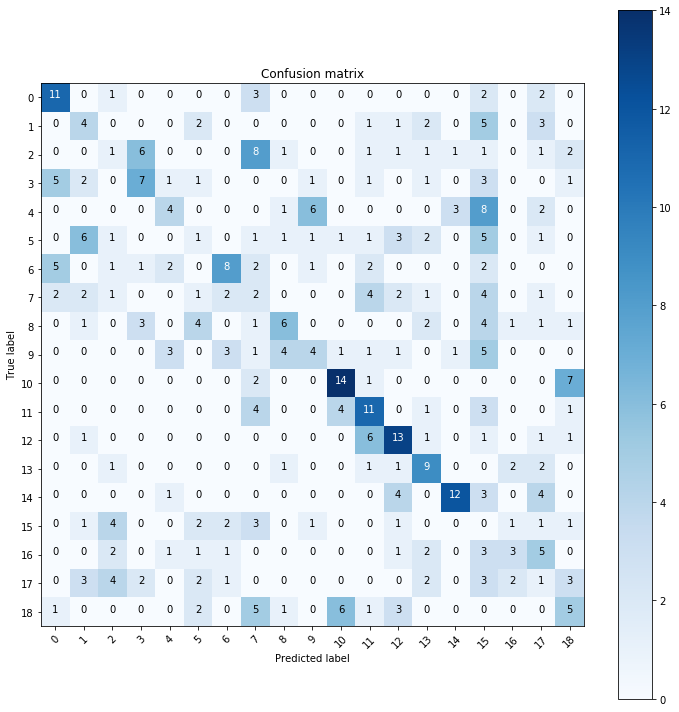

In [31]:
pred = anim.predict(X)
print(metrics.accuracy_score(y, pred))
cm = metrics.confusion_matrix(y, pred)
plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, range(0,19))
plt.show()

In [32]:
X = all_i_data.drop(['l_target', 'h_target'], axis=1)
y = all_i_data['h_target']

0.3181818181818182
Confusion matrix, without normalization
[[ 9  2  0  0  2  0  0  0  0  0  0  0  0  0  0  0  0  6  0  0  0  0  1  3
   0  0  0  0  1  0  0]
 [ 8  8  0  0  0  0  1  0  0  0  0  0  0  0  0  0  2  0  0  0  0  0  4  0
   0  0  1  0  0  0  0]
 [ 0  0  5  2  0  1  0  0  0  0  0  0  7  3  0  1  0  0  0  2  0  0  0  0
   0  3  0  0  0  0  0]
 [ 0  0  0 13  0  0  0  0  0  0  1  0  3  0  1  0  0  0  0  1  0  0  0  0
   0  0  0  0  0  1  1]
 [ 2  2  0  0  3  3  0  0  0  0  0  0  1  0  0  0  0  3  0  0  0  2  0  0
   1  2  0  4  1  0  0]
 [ 0  0  0  1  0 12  1  0  0  2  2  0  0  1  0  0  0  0  0  0  2  0  0  0
   1  0  0  0  0  0  0]
 [ 2  1  0  0  0  2  7  0  0  2  0  0  0  0  0  0  0  4  0  0  0  0  0  2
   0  3  1  0  0  0  0]
 [ 0  0  0  1  1  0  0 15  0  0  0  2  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  1  0  4  0]
 [ 0  0  3  9  0  0  0  0  5  0  1  1  2  0  0  0  0  0  0  1  0  0  0  0
   0  0  0  0  0  0  0]
 [ 9  0  0  0  0  1  1  0  1  4  1  0  0  0  1  0  0  0  0 

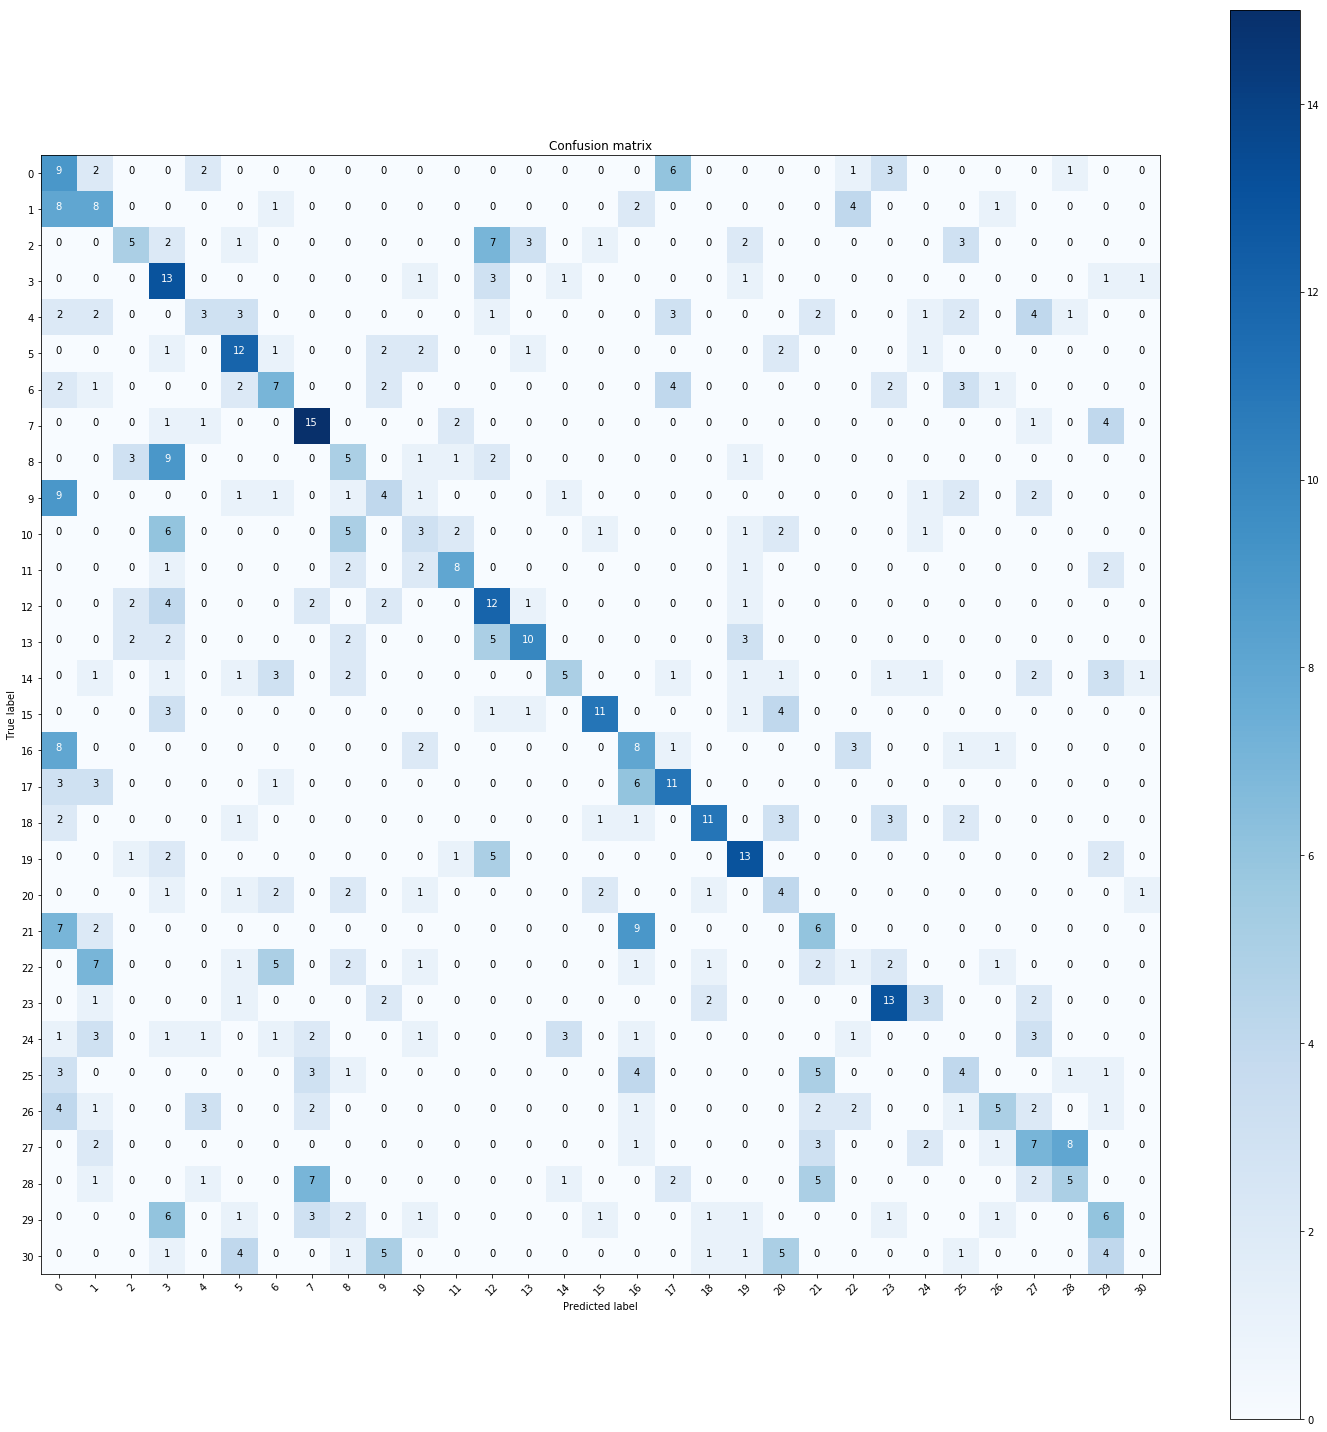

In [33]:
pred = inter.predict(X)
print(metrics.accuracy_score(y, pred))
cm = metrics.confusion_matrix(y, pred)
plt.figure(figsize=(20,20))
plot_confusion_matrix(cm, range(0,31))
plt.show()